Using device: cuda
Applying EMA Smoothing (span=5)...

>>> Start Training GATE-Coord V4 (Hybrid Loss)...
Epoch 10/150 | Val MSE: 1.215514
Epoch 20/150 | Val MSE: 0.154011
Epoch 30/150 | Val MSE: 0.168684
Epoch 40/150 | Val MSE: 0.099850
Epoch 50/150 | Val MSE: 0.064285
Epoch 60/150 | Val MSE: 0.052762
Epoch 70/150 | Val MSE: 0.035079
Epoch 80/150 | Val MSE: 0.020035
Epoch 90/150 | Val MSE: 0.018187
Epoch 100/150 | Val MSE: 0.020873
Epoch 110/150 | Val MSE: 0.017135
Epoch 120/150 | Val MSE: 0.016945
Epoch 130/150 | Val MSE: 0.014463
Epoch 140/150 | Val MSE: 0.013971
Epoch 150/150 | Val MSE: 0.015417

>>> Evaluating...
Generating trajectory...
Final RMSE: 2.8346m
Predictions saved to results/GATE_Cheku.csv


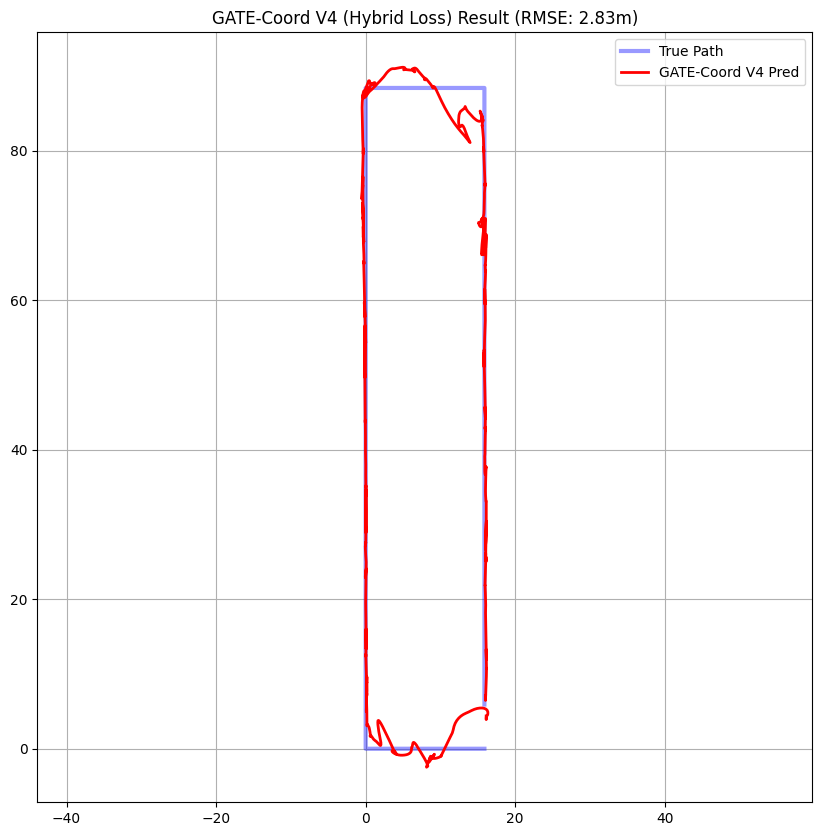

In [1]:
# -*- coding: utf-8 -*-
"""
GATE-Coord V4: 绝对坐标回归 + 速度一致性约束
--------------------------------------------
策略调整:
1. 回归目标: 改回预测绝对坐标 (x, y)，利用 RSSI 指纹特性消除"漂移"。
2. Loss 改进: 引入 Velocity Loss，强制模型不仅位置要准，速度方向也要准 (防抖动)。
3. 架构保持: 继续使用 GATE + CNN 提取空间特征。
4. [新增] 结果保存: 自动将预测结果保存为 CSV 文件。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys

# ------------------------------------------------------------------------------
# 配置部分
# ------------------------------------------------------------------------------
CONFIG = {
    'window_size': 70,      # [调整] 窗口改小一点，减少滞后
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'k_neighbors': 5,
    'num_anchors': 32,
    'hidden_dim': 64,
    'data_dir': '../Datasets',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==============================================================================
#                 1. 模型定义 (GATE + CNN + LSTM -> 预测 Coord)
# ==============================================================================

class GATE_RTEC_Layer(nn.Module):
    def __init__(self, anchors, k):
        super().__init__()
        self.register_buffer('anchors', anchors)
        self.k = k

    def forward(self, x):
        x_norm = F.normalize(x, p=2, dim=1)
        anchors_norm = F.normalize(self.anchors, p=2, dim=1)
        scores = torch.matmul(x_norm, anchors_norm.T)
        topk_scores, topk_indices = torch.topk(scores, self.k, dim=1)
        attn_weights = F.softmax(topk_scores, dim=1).unsqueeze(-1)
        batch_indices = topk_indices
        neighbors = self.anchors[batch_indices]
        f_raw = x.unsqueeze(1)
        f_msg = torch.sum(attn_weights * neighbors, dim=1, keepdim=True)
        f_ahv = f_raw * f_msg
        mdhv = torch.cat([f_raw, f_msg, f_ahv], dim=1).unsqueeze(1)
        return mdhv

class GATE_Coord_Model(nn.Module):
    def __init__(self, anchors, k_neighbors, num_aps):
        super().__init__()
        self.num_aps = num_aps
        
        # 1. 空间特征提取
        self.gate = GATE_RTEC_Layer(anchors, k_neighbors)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(16), nn.GELU(),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32), nn.GELU(),
        )
        self.flatten_dim = 32* 3 * num_aps
        self.spatial_proj = nn.Linear(self.flatten_dim, CONFIG['hidden_dim'])
        
        # 2. 时间特征提取
        self.lstm = nn.LSTM(
            input_size=CONFIG['hidden_dim'], 
            hidden_size=CONFIG['hidden_dim'], 
            num_layers=2, 
            batch_first=True, 
            dropout=0.1
        )
        
        # 3. 回归头 (直接预测 x, y)
        self.regressor = nn.Sequential(
            nn.Linear(CONFIG['hidden_dim'], 64),
            nn.GELU(),
            nn.Linear(64, 2)
        )

    def forward(self, x_seq):
        B, W, N = x_seq.shape
        x_flat = x_seq.reshape(B * W, N)
        
        mdhv = self.gate(x_flat)
        feat_map = self.cnn(mdhv)
        feat_vec = feat_map.view(B * W, -1)
        spatial_feat = self.spatial_proj(feat_vec)
        
        spatial_seq = spatial_feat.view(B, W, -1)
        lstm_out, _ = self.lstm(spatial_seq)
        
        coords = self.regressor(lstm_out) # [B, W, 2]
        return coords

# ==============================================================================
#                 2. 数据处理
# ==============================================================================

class RSSIDataset(Dataset):
    def __init__(self, df, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        wifi_data = df[wifi_cols].values.astype(np.float32)
        coords = df[coord_cols].values.astype(np.float32)
        
        # 物理归一化 RSSI
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi = (wifi_data + 100.0) / 100.0
        
        # 坐标归一化 (StandardScaler)
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(coords)

    def __len__(self): return len(self.wifi) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.wifi[idx : idx + self.window_size]
        y_seq = self.coords[idx : idx + self.window_size]
        return torch.tensor(x_seq), torch.tensor(y_seq)

def get_data_loaders():
    train_path = os.path.join(CONFIG['data_dir'], "x_train.csv")
    val_path = os.path.join(CONFIG['data_dir'], "x_val.csv")
    test_path = os.path.join(CONFIG['data_dir'], "x_test.csv")

    if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print(f"Error: Data files not found in {CONFIG['data_dir']}")
        sys.exit(1)

    train_df = pd.read_csv(train_path, engine='python')
    val_df = pd.read_csv(val_path, engine='python')
    test_df = pd.read_csv(test_path, engine='python')

    # WiFi 列对齐
    # train_wifi = set(c for c in train_df.columns if "RSSI" in c or "distance" in c)
    train_wifi = set(c for c in train_df.columns if "RSSI" in c )
    val_wifi = set(c for c in val_df.columns if "RSSI" in c )
    # val_wifi = set(c for c in val_df.columns if "RSSI" in c or "distance" in c)
    # test_wifi = set(c for c in test_df.columns if "RSSI" in c or "distance" in c)
    test_wifi = set(c for c in test_df.columns if "RSSI" in c )
    common_wifi_cols = list(train_wifi.intersection(val_wifi).intersection(test_wifi))
    common_wifi_cols.sort()
    
    coord_cols = ['x_coord', 'y_coord']
    
    # EMA 平滑 (保持开启，这对去噪很重要)
    print("Applying EMA Smoothing (span=5)...")
    for df in [train_df, val_df, test_df]:
        df[common_wifi_cols] = df[common_wifi_cols].ewm(span=5, min_periods=1).mean()

    # Anchors
    wifi_norm_temp = (train_df[common_wifi_cols].values + 100.0) / 100.0
    wifi_norm_temp = np.clip(wifi_norm_temp, 0.0, 1.0)
    kmeans = KMeans(n_clusters=CONFIG['num_anchors'], n_init=10, random_state=42)
    kmeans.fit(wifi_norm_temp)
    anchors = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(CONFIG['device'])

    train_set = RSSIDataset(train_df, common_wifi_cols, coord_cols, CONFIG['window_size'])
    val_set = RSSIDataset(val_df, common_wifi_cols, coord_cols, CONFIG['window_size'], scaler=None, coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, common_wifi_cols, coord_cols, CONFIG['window_size'], scaler=None, coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=False, drop_last=True),
        DataLoader(val_set, batch_size=CONFIG['batch_size'], shuffle=False),
        test_set,
        anchors,
        train_set.coord_scaler
    )

# ==============================================================================
#                 3. 混合 Loss 函数 (核心改动)
# ==============================================================================

def hybrid_loss(pred_coords, true_coords):
    """
    同时约束位置(Position)和速度(Velocity)
    """
    # 1. 位置误差 (Position Loss) - 确保不漂移
    loss_pos = F.mse_loss(pred_coords, true_coords)
    
    # 2. 速度一致性误差 (Velocity Consistency Loss) - 确保平滑且趋势一致
    # 计算相邻两帧的差分 (即速度向量)
    pred_vel = pred_coords[:, 1:] - pred_coords[:, :-1]
    true_vel = true_coords[:, 1:] - true_coords[:, :-1]
    
    loss_vel = F.mse_loss(pred_vel, true_vel)
    
    # 权重分配：主要看位置，辅助看速度
    return loss_pos + 1.0 * loss_vel

# ==============================================================================
#                 4. 主程序
# ==============================================================================

def main():
    data = get_data_loaders()
    if data is None: return 
    train_loader, val_loader, test_set, anchors, coord_scaler = data
    
    num_aps = anchors.shape[1]
    model = GATE_Coord_Model(anchors, CONFIG['k_neighbors'], num_aps).to(CONFIG['device'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)

    print("\n>>> Start Training GATE-Coord V4 (Hybrid Loss)...")
    best_loss = float('inf')
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            optimizer.zero_grad()
            pred_coords = model(x) 
            loss = hybrid_loss(pred_coords, y) # 使用混合 Loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
                pred_coords = model(x)
                val_loss += F.mse_loss(pred_coords, y).item() # 验证集只看位置准不准
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_gate_coord_v4.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val MSE: {avg_val:.6f}")

    # --- 评估 ---
    print("\n>>> Evaluating...")
    model.load_state_dict(torch.load('best_gate_coord_v4.pth'))
    model.eval()
    
    full_wifi = test_set.wifi
    full_coords = test_set.coords
    
    trajectory = []
    window_size = CONFIG['window_size']
    
    print(f"Generating trajectory...")
    with torch.no_grad():
        batch_inputs = []
        
        # 这里的预测策略改回直接预测坐标
        # 我们对每一个时刻 t，取 [t-W, t] 的窗口来预测 t
        for i in range(len(full_wifi) - window_size):
            x_window = full_wifi[i : i + window_size]
            batch_inputs.append(x_window)
            
            if len(batch_inputs) >= 128 or i == (len(full_wifi) - window_size - 1):
                batch_tensor = torch.tensor(np.array(batch_inputs), device=CONFIG['device'])
                preds = model(batch_tensor)
                
                # 取窗口最后一帧的预测坐标
                last_coords = preds[:, -1, :].cpu().numpy()
                
                for c in last_coords:
                    trajectory.append(c)
                
                batch_inputs = []

    trajectory = np.array(trajectory)
    gt_aligned = full_coords[window_size:] # GT 需要对齐
    
    # 反归一化
    preds_real = coord_scaler.inverse_transform(trajectory)
    targets_real = coord_scaler.inverse_transform(gt_aligned)
    
    # 简单的平滑处理 (Savgol)
    try:
        preds_final_x = savgol_filter(preds_real[:, 0], 21, 2)
        preds_final_y = savgol_filter(preds_real[:, 1], 21, 2)
        preds_final = np.stack([preds_final_x, preds_final_y], axis=1)
    except:
        preds_final = preds_real

    rmse = np.sqrt(np.mean(np.linalg.norm(preds_final - targets_real, axis=1)**2))
    print(f"Final RMSE: {rmse:.4f}m")
    
    # ================= [新增] 保存预测结果到 CSV =================
    # 按要求命名列名: True_X, True_Y, Pred_X, Pred_Y
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets_real[:, 0],
        'True_Y': targets_real[:, 1],
        'Pred_X': preds_final[:, 0],
        'Pred_Y': preds_final[:, 1]
    }).to_csv('results/GATE_Cheku.csv', index=False)
    print("Predictions saved to results/GATE_Cheku.csv")
    # =============================================================

    plt.figure(figsize=(10, 10))
    plt.plot(targets_real[:, 0], targets_real[:, 1], 'b-', label='True Path', linewidth=3, alpha=0.4)
    plt.plot(preds_final[:, 0], preds_final[:, 1], 'r-', label='GATE-Coord V4 Pred', linewidth=2)
    plt.title(f"GATE-Coord V4 (Hybrid Loss) Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig('Picture/GATE_Coord_V4_Result.png')
    # print("Plot saved to Picture/GATE_Coord_V4_Result.png")

if __name__ == '__main__':
    main()


Using device: cuda
Applying EMA Smoothing (span=5)...

>>> Start Training GATE-Coord V4 (Hybrid Loss)...
Epoch 10/150 | Val MSE: 0.199082
Epoch 20/150 | Val MSE: 0.122112
Epoch 30/150 | Val MSE: 0.091496
Epoch 40/150 | Val MSE: 0.076584
Epoch 50/150 | Val MSE: 0.067277
Epoch 60/150 | Val MSE: 0.063003
Epoch 70/150 | Val MSE: 0.059876
Epoch 80/150 | Val MSE: 0.062765
Epoch 90/150 | Val MSE: 0.051046
Epoch 100/150 | Val MSE: 0.044951
Epoch 110/150 | Val MSE: 0.044948
Epoch 120/150 | Val MSE: 0.048461
Epoch 130/150 | Val MSE: 0.046986
Epoch 140/150 | Val MSE: 0.047352
Epoch 150/150 | Val MSE: 0.048219

>>> Evaluating & Measuring Speed...
Pre-warming model...
Warm-up done.
Generating trajectory...

INFERENCE SPEED REPORT (GATE-Coord V4)
--------------------------------------------------
Total Samples:        726
Total Time:           0.0230 s
FPS (Samples/Sec):    31598.30
Avg Time per Sample:  0.0316 ms

Final RMSE: 1.7559m
Predictions saved to results/GATE_Cheku.csv


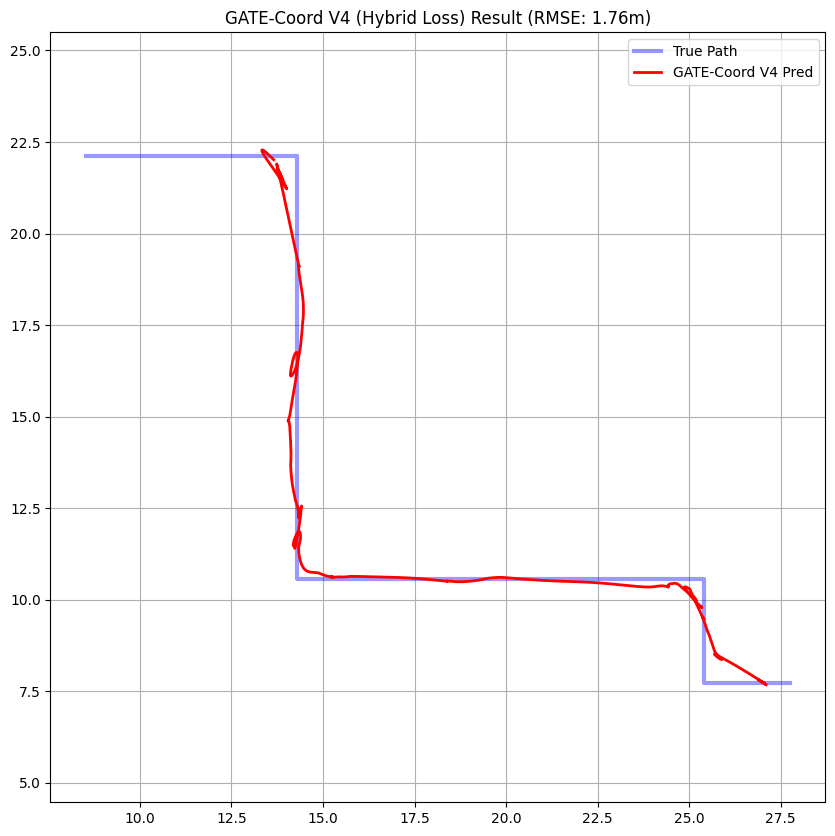

In [2]:
# -*- coding: utf-8 -*-
"""
GATE-Coord V4: 绝对坐标回归 + 速度一致性约束 (含推理耗时统计)
--------------------------------------------
策略调整:
1. 回归目标: 改回预测绝对坐标 (x, y)，利用 RSSI 指纹特性消除"漂移"。
2. Loss 改进: 引入 Velocity Loss，强制模型不仅位置要准，速度方向也要准 (防抖动)。
3. 架构保持: 继续使用 GATE + CNN 提取空间特征。
4. [新增] 结果保存: 自动将预测结果保存为 CSV 文件。
5. [新增] 性能统计: 增加毫秒级推理耗时和 FPS 统计。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
import time  # <--- 【新增】引入 time 模块

# ------------------------------------------------------------------------------
# 配置部分
# ------------------------------------------------------------------------------
CONFIG = {
    'window_size': 70,      # [调整] 窗口改小一点，减少滞后
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'k_neighbors': 5,
    'num_anchors': 32,
    'hidden_dim': 64,
    'data_dir': '../Datasets',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==============================================================================
#                 1. 模型定义 (GATE + CNN + LSTM -> 预测 Coord)
# ==============================================================================

class GATE_RTEC_Layer(nn.Module):
    def __init__(self, anchors, k):
        super().__init__()
        self.register_buffer('anchors', anchors)
        self.k = k

    def forward(self, x):
        x_norm = F.normalize(x, p=2, dim=1)
        anchors_norm = F.normalize(self.anchors, p=2, dim=1)
        scores = torch.matmul(x_norm, anchors_norm.T)
        topk_scores, topk_indices = torch.topk(scores, self.k, dim=1)
        attn_weights = F.softmax(topk_scores, dim=1).unsqueeze(-1)
        batch_indices = topk_indices
        neighbors = self.anchors[batch_indices]
        f_raw = x.unsqueeze(1)
        f_msg = torch.sum(attn_weights * neighbors, dim=1, keepdim=True)
        f_ahv = f_raw * f_msg
        mdhv = torch.cat([f_raw, f_msg, f_ahv], dim=1).unsqueeze(1)
        return mdhv

class GATE_Coord_Model(nn.Module):
    def __init__(self, anchors, k_neighbors, num_aps):
        super().__init__()
        self.num_aps = num_aps
        
        # 1. 空间特征提取
        self.gate = GATE_RTEC_Layer(anchors, k_neighbors)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32), nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64), nn.GELU(),
        )
        self.flatten_dim = 64 * 3 * num_aps
        self.spatial_proj = nn.Linear(self.flatten_dim, CONFIG['hidden_dim'])
        
        # 2. 时间特征提取
        self.lstm = nn.LSTM(
            input_size=CONFIG['hidden_dim'], 
            hidden_size=CONFIG['hidden_dim'], 
            num_layers=2, 
            batch_first=True, 
            dropout=0.1
        )
        
        # 3. 回归头 (直接预测 x, y)
        self.regressor = nn.Sequential(
            nn.Linear(CONFIG['hidden_dim'], 64),
            nn.GELU(),
            nn.Linear(64, 2)
        )

    def forward(self, x_seq):
        B, W, N = x_seq.shape
        x_flat = x_seq.reshape(B * W, N)
        
        mdhv = self.gate(x_flat)
        feat_map = self.cnn(mdhv)
        feat_vec = feat_map.view(B * W, -1)
        spatial_feat = self.spatial_proj(feat_vec)
        
        spatial_seq = spatial_feat.view(B, W, -1)
        lstm_out, _ = self.lstm(spatial_seq)
        
        coords = self.regressor(lstm_out) # [B, W, 2]
        return coords

# ==============================================================================
#                 2. 数据处理
# ==============================================================================

class RSSIDataset(Dataset):
    def __init__(self, df, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        wifi_data = df[wifi_cols].values.astype(np.float32)
        coords = df[coord_cols].values.astype(np.float32)
        
        # 物理归一化 RSSI
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi = (wifi_data + 100.0) / 100.0
        
        # 坐标归一化 (StandardScaler)
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(coords)

    def __len__(self): return len(self.wifi) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.wifi[idx : idx + self.window_size]
        y_seq = self.coords[idx : idx + self.window_size]
        return torch.tensor(x_seq), torch.tensor(y_seq)

def get_data_loaders():
    train_path = os.path.join(CONFIG['data_dir'], "zoulang/train.csv")
    val_path = os.path.join(CONFIG['data_dir'], "zoulang/validation.csv")
    test_path = os.path.join(CONFIG['data_dir'], "zoulang/test.csv")

    if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
        print(f"Error: Data files not found in {CONFIG['data_dir']}")
        sys.exit(1)

    train_df = pd.read_csv(train_path, engine='python')
    val_df = pd.read_csv(val_path, engine='python')
    test_df = pd.read_csv(test_path, engine='python')

    # WiFi 列对齐
    train_wifi = set(c for c in train_df.columns if "RSSI" in c )
    val_wifi = set(c for c in val_df.columns if "RSSI" in c )
    test_wifi = set(c for c in test_df.columns if "RSSI" in c )
    common_wifi_cols = list(train_wifi.intersection(val_wifi).intersection(test_wifi))
    common_wifi_cols.sort()
    
    coord_cols = ['x_coord', 'y_coord']
    
    # EMA 平滑 (保持开启，这对去噪很重要)
    print("Applying EMA Smoothing (span=5)...")
    for df in [train_df, val_df, test_df]:
        df[common_wifi_cols] = df[common_wifi_cols].ewm(span=5, min_periods=1).mean()

    # Anchors
    wifi_norm_temp = (train_df[common_wifi_cols].values + 100.0) / 100.0
    wifi_norm_temp = np.clip(wifi_norm_temp, 0.0, 1.0)
    kmeans = KMeans(n_clusters=CONFIG['num_anchors'], n_init=10, random_state=42)
    kmeans.fit(wifi_norm_temp)
    anchors = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(CONFIG['device'])

    train_set = RSSIDataset(train_df, common_wifi_cols, coord_cols, CONFIG['window_size'])
    val_set = RSSIDataset(val_df, common_wifi_cols, coord_cols, CONFIG['window_size'], scaler=None, coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, common_wifi_cols, coord_cols, CONFIG['window_size'], scaler=None, coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=False, drop_last=True),
        DataLoader(val_set, batch_size=CONFIG['batch_size'], shuffle=False),
        test_set,
        anchors,
        train_set.coord_scaler
    )

# ==============================================================================
#                 3. 混合 Loss 函数 (核心改动)
# ==============================================================================

def hybrid_loss(pred_coords, true_coords):
    """
    同时约束位置(Position)和速度(Velocity)
    """
    # 1. 位置误差 (Position Loss) - 确保不漂移
    loss_pos = F.mse_loss(pred_coords, true_coords)
    
    # 2. 速度一致性误差 (Velocity Consistency Loss) - 确保平滑且趋势一致
    # 计算相邻两帧的差分 (即速度向量)
    pred_vel = pred_coords[:, 1:] - pred_coords[:, :-1]
    true_vel = true_coords[:, 1:] - true_coords[:, :-1]
    
    loss_vel = F.mse_loss(pred_vel, true_vel)
    
    # 权重分配：主要看位置，辅助看速度
    return loss_pos + 1.0 * loss_vel

# ==============================================================================
#                 4. 主程序
# ==============================================================================

def main():
    data = get_data_loaders()
    if data is None: return 
    train_loader, val_loader, test_set, anchors, coord_scaler = data
    
    num_aps = anchors.shape[1]
    model = GATE_Coord_Model(anchors, CONFIG['k_neighbors'], num_aps).to(CONFIG['device'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)

    print("\n>>> Start Training GATE-Coord V4 (Hybrid Loss)...")
    best_loss = float('inf')
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            optimizer.zero_grad()
            pred_coords = model(x) 
            loss = hybrid_loss(pred_coords, y) # 使用混合 Loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
                pred_coords = model(x)
                val_loss += F.mse_loss(pred_coords, y).item() # 验证集只看位置准不准
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_gate_coord_v4.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val MSE: {avg_val:.6f}")

    # --- 评估 ---
    print("\n>>> Evaluating & Measuring Speed...")
    model.load_state_dict(torch.load('best_gate_coord_v4.pth'))
    model.eval()
    
    full_wifi = test_set.wifi
    full_coords = test_set.coords
    
    trajectory = []
    window_size = CONFIG['window_size']
    
    # --- 【新增】 计时统计变量 ---
    total_inference_time = 0.0
    total_samples_inference = 0
    
    # --- 【新增】 预热模型 (Warm-up) ---
    print("Pre-warming model...")
    if len(full_wifi) > window_size:
        dummy_input = torch.tensor(full_wifi[:window_size]).unsqueeze(0).to(CONFIG['device']) # [1, W, N]
        with torch.no_grad():
            _ = model(dummy_input)
    print("Warm-up done.")

    print(f"Generating trajectory...")
    with torch.no_grad():
        batch_inputs = []
        
        # 这里的预测策略改回直接预测坐标
        # 我们对每一个时刻 t，取 [t-W, t] 的窗口来预测 t
        for i in range(len(full_wifi) - window_size):
            x_window = full_wifi[i : i + window_size]
            batch_inputs.append(x_window)
            
            # 当收集到一个 Batch 或者到了最后一个数据
            if len(batch_inputs) >= 128 or i == (len(full_wifi) - window_size - 1):
                batch_tensor = torch.tensor(np.array(batch_inputs), device=CONFIG['device'])
                
                # --- 【新增】 开始计时 ---
                if CONFIG['device'] == 'cuda':
                    torch.cuda.synchronize() # 确保 GPU 之前的任务已完成
                t0 = time.time()
                
                # 模型推理
                preds = model(batch_tensor)
                
                # --- 【新增】 结束计时 ---
                if CONFIG['device'] == 'cuda':
                    torch.cuda.synchronize() # 确保 GPU 推理已完成
                t1 = time.time()
                
                # 累加统计
                total_inference_time += (t1 - t0)
                total_samples_inference += batch_tensor.size(0)
                
                # 取窗口最后一帧的预测坐标
                last_coords = preds[:, -1, :].cpu().numpy()
                
                for c in last_coords:
                    trajectory.append(c)
                
                batch_inputs = []

    # --- 【新增】 输出速度报告 ---
    avg_time_ms = (total_inference_time / total_samples_inference) * 1000
    fps = total_samples_inference / total_inference_time
    
    print("\n" + "="*50)
    print(f"INFERENCE SPEED REPORT (GATE-Coord V4)")
    print("-" * 50)
    print(f"Total Samples:        {total_samples_inference}")
    print(f"Total Time:           {total_inference_time:.4f} s")
    print(f"FPS (Samples/Sec):    {fps:.2f}")
    print(f"Avg Time per Sample:  {avg_time_ms:.4f} ms")
    print("="*50 + "\n")

    trajectory = np.array(trajectory)
    gt_aligned = full_coords[window_size:] # GT 需要对齐
    
    # 反归一化
    preds_real = coord_scaler.inverse_transform(trajectory)
    targets_real = coord_scaler.inverse_transform(gt_aligned)
    
    # 简单的平滑处理 (Savgol)
    try:
        preds_final_x = savgol_filter(preds_real[:, 0], 21, 2)
        preds_final_y = savgol_filter(preds_real[:, 1], 21, 2)
        preds_final = np.stack([preds_final_x, preds_final_y], axis=1)
    except:
        preds_final = preds_real

    rmse = np.sqrt(np.mean(np.linalg.norm(preds_final - targets_real, axis=1)**2))
    print(f"Final RMSE: {rmse:.4f}m")
    
    # ================= [新增] 保存预测结果到 CSV =================
    # 按要求命名列名: True_X, True_Y, Pred_X, Pred_Y
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets_real[:, 0],
        'True_Y': targets_real[:, 1],
        'Pred_X': preds_final[:, 0],
        'Pred_Y': preds_final[:, 1]
    }).to_csv('results/GATE_Cheku.csv', index=False)
    print("Predictions saved to results/GATE_Cheku.csv")
    # =============================================================

    plt.figure(figsize=(10, 10))
    plt.plot(targets_real[:, 0], targets_real[:, 1], 'b-', label='True Path', linewidth=3, alpha=0.4)
    plt.plot(preds_final[:, 0], preds_final[:, 1], 'r-', label='GATE-Coord V4 Pred', linewidth=2)
    plt.title(f"GATE-Coord V4 (Hybrid Loss) Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig('Picture/GATE_Coord_V4_Result.png')
    # print("Plot saved to Picture/GATE_Coord_V4_Result.png")

if __name__ == '__main__':
    main()

Using device: cuda
Loading full dataset from: ../Datasets\0.15_Speed_OB.csv
Total samples: 20365
Splitting -> Train: 0-16292, Val: 16292-18328, Test: 18328-20365
Applying EMA Smoothing (span=5)...
Generating Anchors from Training data...

>>> Start Training GATE-Coord V4 (Hybrid Loss)...
Epoch 10/150 | Val MSE: 1.306366
Epoch 20/150 | Val MSE: 1.355764
Epoch 30/150 | Val MSE: 1.315122
Epoch 40/150 | Val MSE: 1.306260
Epoch 50/150 | Val MSE: 1.320991
Epoch 60/150 | Val MSE: 1.357840
Epoch 70/150 | Val MSE: 1.362874
Epoch 80/150 | Val MSE: 1.352459
Epoch 90/150 | Val MSE: 1.357972
Epoch 100/150 | Val MSE: 1.353045
Epoch 110/150 | Val MSE: 1.358242
Epoch 120/150 | Val MSE: 1.356117
Epoch 130/150 | Val MSE: 1.356983
Epoch 140/150 | Val MSE: 1.358239
Epoch 150/150 | Val MSE: 1.357709

>>> Evaluating on Test Split (Last 10%)...
Generating trajectory...
Final RMSE: 1.7402m
Predictions saved to results/GATE_0.15_Speed_OB.csv


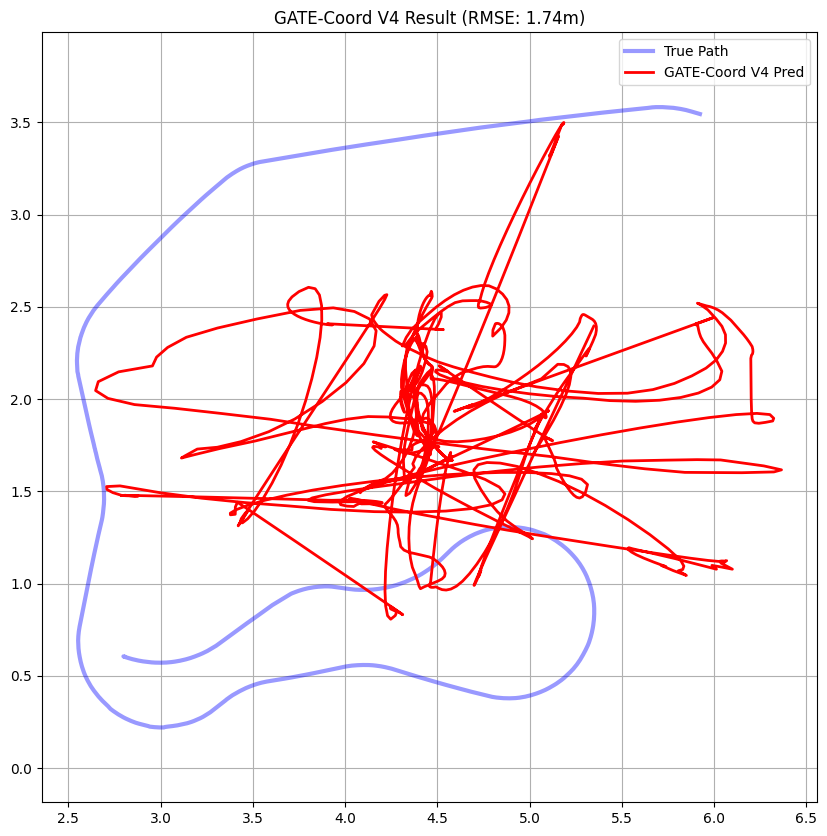

In [2]:
# -*- coding: utf-8 -*-
"""
GATE-Coord V4 (Single Dataset Split): 绝对坐标回归 + 速度一致性约束
-----------------------------------------------------------------
修改点:
1. 数据加载: 读取单个CSV文件，按 8:1:1 顺序切分为 Train/Val/Test。
   注意：必须保持顺序切分，不能随机打乱，因为 LSTM 需要连续轨迹。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys

# ------------------------------------------------------------------------------
# 配置部分
# ------------------------------------------------------------------------------
CONFIG = {
    'window_size': 40,
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'k_neighbors': 5,
    'num_anchors': 32,
    'hidden_dim': 64,
    
    # [修改] 数据路径配置
    'data_dir': '../Datasets',      # 文件夹路径
    'filename': '0.15_Speed_OB.csv',  # [请修改] 这里填你那个单独的大文件名
    
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==============================================================================
#                 1. 模型定义 (保持不变)
# ==============================================================================

class GATE_RTEC_Layer(nn.Module):
    def __init__(self, anchors, k):
        super().__init__()
        self.register_buffer('anchors', anchors)
        self.k = k

    def forward(self, x):
        x_norm = F.normalize(x, p=2, dim=1)
        anchors_norm = F.normalize(self.anchors, p=2, dim=1)
        scores = torch.matmul(x_norm, anchors_norm.T)
        topk_scores, topk_indices = torch.topk(scores, self.k, dim=1)
        attn_weights = F.softmax(topk_scores, dim=1).unsqueeze(-1)
        batch_indices = topk_indices
        neighbors = self.anchors[batch_indices]
        f_raw = x.unsqueeze(1)
        f_msg = torch.sum(attn_weights * neighbors, dim=1, keepdim=True)
        f_ahv = f_raw * f_msg
        mdhv = torch.cat([f_raw, f_msg, f_ahv], dim=1).unsqueeze(1)
        return mdhv

class GATE_Coord_Model(nn.Module):
    def __init__(self, anchors, k_neighbors, num_aps):
        super().__init__()
        self.num_aps = num_aps
        self.gate = GATE_RTEC_Layer(anchors, k_neighbors)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(32), nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(64), nn.GELU(),
        )
        self.flatten_dim = 64 * 3 * num_aps
        self.spatial_proj = nn.Linear(self.flatten_dim, CONFIG['hidden_dim'])
        self.lstm = nn.LSTM(
            input_size=CONFIG['hidden_dim'], 
            hidden_size=CONFIG['hidden_dim'], 
            num_layers=2, 
            batch_first=True, 
            dropout=0.1
        )
        self.regressor = nn.Sequential(
            nn.Linear(CONFIG['hidden_dim'], 64),
            nn.GELU(),
            nn.Linear(64, 2)
        )

    def forward(self, x_seq):
        B, W, N = x_seq.shape
        x_flat = x_seq.reshape(B * W, N)
        mdhv = self.gate(x_flat)
        feat_map = self.cnn(mdhv)
        feat_vec = feat_map.view(B * W, -1)
        spatial_feat = self.spatial_proj(feat_vec)
        spatial_seq = spatial_feat.view(B, W, -1)
        lstm_out, _ = self.lstm(spatial_seq)
        coords = self.regressor(lstm_out)
        return coords

# ==============================================================================
#                 2. 数据处理 (核心修改: 单文件加载与切分)
# ==============================================================================

class RSSIDataset(Dataset):
    def __init__(self, df, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        # 必须重置索引，否则切分后的切片索引不连续会报错
        self.df = df.reset_index(drop=True)
        
        wifi_data = self.df[wifi_cols].values.astype(np.float32)
        coords = self.df[coord_cols].values.astype(np.float32)
        
        # 物理归一化 RSSI
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi = (wifi_data + 100.0) / 100.0
        
        # 坐标归一化 (StandardScaler)
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(coords)

    def __len__(self): return len(self.wifi) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.wifi[idx : idx + self.window_size]
        y_seq = self.coords[idx : idx + self.window_size]
        return torch.tensor(x_seq), torch.tensor(y_seq)

def get_data_loaders():
    # [修改] 读取单个文件
    full_path = os.path.join(CONFIG['data_dir'], CONFIG['filename'])

    if not os.path.exists(full_path):
        print(f"Error: Data file not found at {full_path}")
        sys.exit(1)

    print(f"Loading full dataset from: {full_path}")
    full_df = pd.read_csv(full_path, engine='python')
    
    # [修改] 按 8:1:1 计算切分索引
    total_len = len(full_df)
    train_end = int(total_len * 0.8)
    val_end = int(total_len * 0.9)
    
    print(f"Total samples: {total_len}")
    print(f"Splitting -> Train: 0-{train_end}, Val: {train_end}-{val_end}, Test: {val_end}-{total_len}")

    # [注意] 这里必须使用 iloc 切片并 copy，且不做 shuffle
    # 因为 LSTM 依赖数据的时序连续性，打乱了就没法做滑动窗口了
    train_df = full_df.iloc[:train_end].copy()
    val_df = full_df.iloc[train_end:val_end].copy()
    test_df = full_df.iloc[val_end:].copy()

    # 识别 WiFi 列
    # wifi_cols = [c for c in full_df.columns if "RSSI" in c or "distance" in c]
    wifi_cols = [c for c in full_df.columns if "RSSI" in c or "rot" in c]
    coord_cols = ['x_coord', 'y_coord']
    
    if len(wifi_cols) == 0:
        print("Error: No RSSI columns found!")
        sys.exit(1)

    # EMA 平滑 (保持开启)
    print("Applying EMA Smoothing (span=5)...")
    # 分别平滑，防止数据泄漏 (Train 的未来信息泄漏到 Test)
    for df in [train_df, val_df, test_df]:
        df[wifi_cols] = df[wifi_cols].ewm(span=5, min_periods=1).mean()

    # Anchors (仅使用 Train 生成)
    print("Generating Anchors from Training data...")
    wifi_norm_temp = (train_df[wifi_cols].values + 100.0) / 100.0
    wifi_norm_temp = np.clip(wifi_norm_temp, 0.0, 1.0)
    kmeans = KMeans(n_clusters=CONFIG['num_anchors'], n_init=10, random_state=42)
    kmeans.fit(wifi_norm_temp)
    anchors = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(CONFIG['device'])

    # 创建 Dataset
    train_set = RSSIDataset(train_df, wifi_cols, coord_cols, CONFIG['window_size'])
    # Val 和 Test 使用 Train 的 scaler
    val_set = RSSIDataset(val_df, wifi_cols, coord_cols, CONFIG['window_size'], scaler=None, coord_scaler=train_set.coord_scaler)
    test_set = RSSIDataset(test_df, wifi_cols, coord_cols, CONFIG['window_size'], scaler=None, coord_scaler=train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=CONFIG['batch_size'], shuffle=False),
        test_set,
        anchors,
        train_set.coord_scaler
    )

# ==============================================================================
#                 3. Loss 函数
# ==============================================================================

def hybrid_loss(pred_coords, true_coords):
    loss_pos = F.mse_loss(pred_coords, true_coords)
    pred_vel = pred_coords[:, 1:] - pred_coords[:, :-1]
    true_vel = true_coords[:, 1:] - true_coords[:, :-1]
    loss_vel = F.mse_loss(pred_vel, true_vel)
    return loss_pos + 1.0 * loss_vel

# ==============================================================================
#                 4. 主程序
# ==============================================================================

def main():
    data = get_data_loaders()
    if data is None: return 
    train_loader, val_loader, test_set, anchors, coord_scaler = data
    
    num_aps = anchors.shape[1]
    model = GATE_Coord_Model(anchors, CONFIG['k_neighbors'], num_aps).to(CONFIG['device'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)

    print("\n>>> Start Training GATE-Coord V4 (Hybrid Loss)...")
    best_loss = float('inf')
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            optimizer.zero_grad()
            pred_coords = model(x) 
            loss = hybrid_loss(pred_coords, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
                pred_coords = model(x)
                val_loss += F.mse_loss(pred_coords, y).item()
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_gate_coord_v4.pth')
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val MSE: {avg_val:.6f}")

    # --- 评估 ---
    print("\n>>> Evaluating on Test Split (Last 10%)...")
    model.load_state_dict(torch.load('best_gate_coord_v4.pth'))
    model.eval()
    
    full_wifi = test_set.wifi
    full_coords = test_set.coords
    
    trajectory = []
    window_size = CONFIG['window_size']
    
    print(f"Generating trajectory...")
    with torch.no_grad():
        batch_inputs = []
        for i in range(len(full_wifi) - window_size):
            x_window = full_wifi[i : i + window_size]
            batch_inputs.append(x_window)
            
            if len(batch_inputs) >= 128 or i == (len(full_wifi) - window_size - 1):
                batch_tensor = torch.tensor(np.array(batch_inputs), device=CONFIG['device'])
                preds = model(batch_tensor)
                last_coords = preds[:, -1, :].cpu().numpy()
                for c in last_coords:
                    trajectory.append(c)
                batch_inputs = []

    trajectory = np.array(trajectory)
    gt_aligned = full_coords[window_size:]
    
    # 反归一化
    preds_real = coord_scaler.inverse_transform(trajectory)
    targets_real = coord_scaler.inverse_transform(gt_aligned)
    
    # 平滑处理
    try:
        preds_final_x = savgol_filter(preds_real[:, 0], 21, 2)
        preds_final_y = savgol_filter(preds_real[:, 1], 21, 2)
        preds_final = np.stack([preds_final_x, preds_final_y], axis=1)
    except:
        preds_final = preds_real

    rmse = np.sqrt(np.mean(np.linalg.norm(preds_final - targets_real, axis=1)**2))
    print(f"Final RMSE: {rmse:.4f}m")
    
    # 保存结果
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets_real[:, 0],
        'True_Y': targets_real[:, 1],
        'Pred_X': preds_final[:, 0],
        'Pred_Y': preds_final[:, 1]
    }).to_csv('results/GATE_0.15_Speed_OB.csv', index=False)
    print("Predictions saved to results/GATE_0.15_Speed_OB.csv")

    plt.figure(figsize=(10, 10))
    plt.plot(targets_real[:, 0], targets_real[:, 1], 'b-', label='True Path', linewidth=3, alpha=0.4)
    plt.plot(preds_final[:, 0], preds_final[:, 1], 'r-', label='GATE-Coord V4 Pred', linewidth=2)
    plt.title(f"GATE-Coord V4 Result (RMSE: {rmse:.2f}m)")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    os.makedirs('Picture', exist_ok=True)
    # plt.savefig('Picture/GATE_Coord_V4_Result.png')
    # print("Plot saved to Picture/GATE_Coord_V4_Result.png")

if __name__ == '__main__':
    main()